# 2021 Fantasy Football

### GOAL: to create a draft assistant that selects and ideal lineup

### What is needed or data required
- historical data for player and team performance
- depth charts

### Methods
- linear regression
- XGBoost
- other ML techniques

## Data

### Fetching and Loading Data - Previous Year's Fantasy Football Results

In [1]:
from bs4 import BeautifulSoup
import os
import pandas as pd
import requests
from tqdm import tqdm

In [2]:
# fetch and/or load historical FF performance data

force_update = False

YEARS = [2020, 2019, 2018, 2017, 2016]
URL_FF_START = 'https://www.pro-football-reference.com/years/'
URL_FF_END = '/fantasy.htm'

# checking if data already exists ========================================
FETCH = False
FOUND_YEARS = []

for year in YEARS:
    if os.path.isfile(f'./data/{year}_ff_rankings.csv'):
        FOUND_YEARS.append(year)

if set(FOUND_YEARS) != set(YEARS):
    GET_YEARS = []
    for year in YEARS:
        if year not in FOUND_YEARS:
            GET_YEARS.append(year)
    FETCH = True
# ========================================================================
if FETCH or force_update:
    print('Gathering data...')
    
    # check if folder exists, if not, create it
    if os.path.isdir('./data') is False:
        os.mkdir('data')

    for year in tqdm(GET_YEARS):
        r = requests.get(URL_FF_START + str(year) + URL_FF_END, 'lxml')
        df = pd.read_html(r.text, index_col=0)[0]

        # fixing column names ============================================
        df.columns = df.columns.to_flat_index()
        df.columns = ["_".join(x) for x in df.columns]
        
        for col in df.columns:
            if col[:3] == 'Unn':
                df.rename(columns={col: col.split('_')[-1]}, inplace=True)
        # ================================================================
        
        # other various fixes
        df = df[df['Tm'] != 'Tm']
        
        df[df.columns[4:]] = df[df.columns[4:]].fillna(value=0)
        
        df['FantPos'] = df['FantPos'].fillna('UNKN')
        df['FantPos'] = df['FantPos'].apply(lambda x: str(x).upper())
        
        df['Player'] = df['Player'].apply(lambda x: x.replace('*', ' '))
        df['Player'] = df['Player'].apply(lambda x: x.replace('+', ' '))
        df['Player'] = df['Player'].apply(lambda x: x.strip().upper())
        
        df.to_csv(f'./data/{year}_ff_rankings.csv')

# loading in data
ffranks_dfs = []
for year in YEARS:
    year_df = pd.read_csv(f'./data/{year}_ff_rankings.csv', index_col=0)
    year_df['for_year'] = year

    ffranks_dfs.append(year_df)
        
ffrank_df = pd.concat(ffranks_dfs, ignore_index=True)

'''
Can now access individual year frames or a combined frame. Most likely,
just want to access the combine frame, so I'll only clean that
'''

ffrank_df.head()
    

,Player,Tm,FantPos,Age,Games_G,Games_GS,Passing_Cmp,Passing_Att,Passing_Yds,Passing_TD,...,Scoring_2PM,Scoring_2PP,Fantasy_FantPt,Fantasy_PPR,Fantasy_DKPt,Fantasy_FDPt,Fantasy_VBD,Fantasy_PosRank,Fantasy_OvRank,for_year
0,DERRICK HENRY,TEN,RB,26,16,16,0,0,0,0,...,1,0,314,333.1,341.1,323.6,184,1,1,2020
1,ALVIN KAMARA,NOR,RB,25,15,10,0,0,0,0,...,0,0,295,377.8,383.8,336.3,165,2,2,2020
2,DALVIN COOK,MIN,RB,25,14,14,0,0,0,0,...,3,0,294,337.8,346.8,315.8,164,3,3,2020
3,TRAVIS KELCE,KAN,TE,31,15,15,1,2,4,0,...,1,0,208,312.8,316.8,260.3,117,1,4,2020
4,DAVANTE ADAMS,GNB,WR,28,14,14,0,0,0,0,...,0,0,243,358.4,362.4,300.9,117,1,5,2020


### Data Cleaning

In [3]:
# converting columns to necessary types - may be a bit overkill
types_dict = {'Player': str, 'Tm': str, 'FantPos': str, 'Age': int,
              'Games_G': int, 'Games_GS': int, 'Passing_Cmp': float,
              'Passing_Att': int, 'Passing_Yds': float, 'Passing_TD': int,
              'Passing_Int': int, 'Rushing_Att': int, 'Rushing_Yds': float,
              'Rushing_Y/A': float, 'Rushing_TD': float, 'Receiving_Tgt': int,
              'Receiving_Rec': int, 'Receiving_Yds': float, 'Receiving_Y/R': float,
              'Receiving_TD': int, 'Fumbles_Fmb': int, 'Fumbles_FL': int,
              'Scoring_TD': int, 'Scoring_2PM': int, 'Scoring_2PP': int,
              'Fantasy_FantPt': float, 'Fantasy_PPR': float, 'Fantasy_DKPt': float,
              'Fantasy_FDPt': float, 'Fantasy_VBD': float, 'Fantasy_PosRank': int,
              'Fantasy_OvRank': int, 'for_year': int}

ffrank_df = ffrank_df.astype(types_dict)

## EDA

Questions:
- Which age would be considered prime? Does this change by position?
- Which positions produce the most fantasy points?
- Which positions does quality matter most?
    - for instance, is there a greater disparity in quality amongst QBs than RBs?

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

In [5]:
MIN_GAMES = 8

ffrank_df = ffrank_df[ffrank_df['Games_G'] >= MIN_GAMES]
ffrank_df['FantPt/G'] = ffrank_df['Fantasy_FantPt'] / ffrank_df['Games_G']

### Athlete's Prime

In [6]:
prime_df = ffrank_df[['FantPos', 'Player', 'Age', 'FantPt/G', 'Fantasy_FantPt']]
min_age = prime_df['Age'].min()
max_age = prime_df['Age'].max()

age_dict = {}
for i in range(min_age, max_age+1):
    _series = prime_df[prime_df['Age'] == i]['FantPt/G']
    if len(_series) >= 30:
        mean = _series.mean()
        std = _series.std()
        age_dict[i] = {'mean': mean, 'std': std}

agg_prime_df = pd.DataFrame.from_dict(age_dict, orient='index')
agg_prime_df

,mean,std
21,6.579712,4.732348
22,5.582191,5.130109
23,4.985425,5.189155
24,4.584035,4.820650
25,4.874380,4.972625
26,4.316579,4.340187
27,4.868029,4.138598
28,5.068147,4.814736
29,5.504863,5.197668
30,5.290815,4.589474


Text(0.5, 1.0, 'Fantasy Points vs. Age')

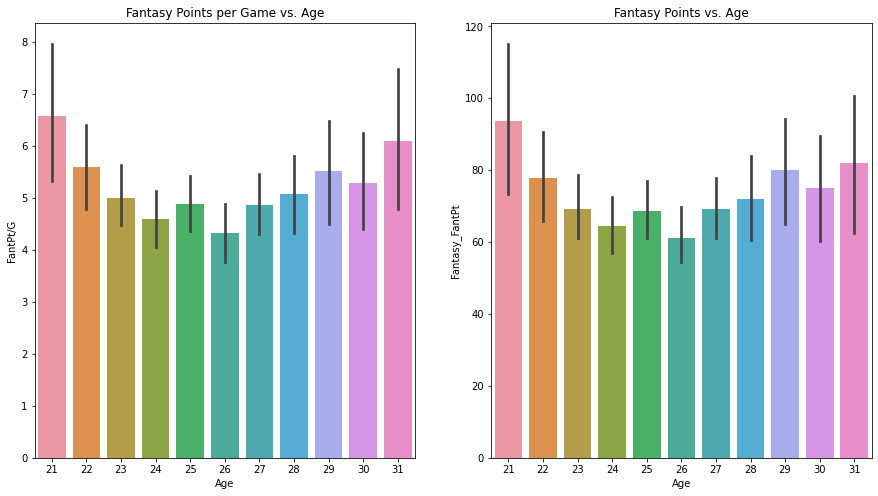

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

sns.barplot(x="Age", y="FantPt/G", data=prime_df[prime_df['Age']<=31], ax=ax1)
ax1.set_title('Fantasy Points per Game vs. Age')

sns.barplot(x="Age", y="Fantasy_FantPt", data=prime_df[prime_df['Age']<=31], ax=ax2)
ax2.set_title('Fantasy Points vs. Age')


Text(0.5, 1.0, 'Fantasy Points vs. Age (QBs)')

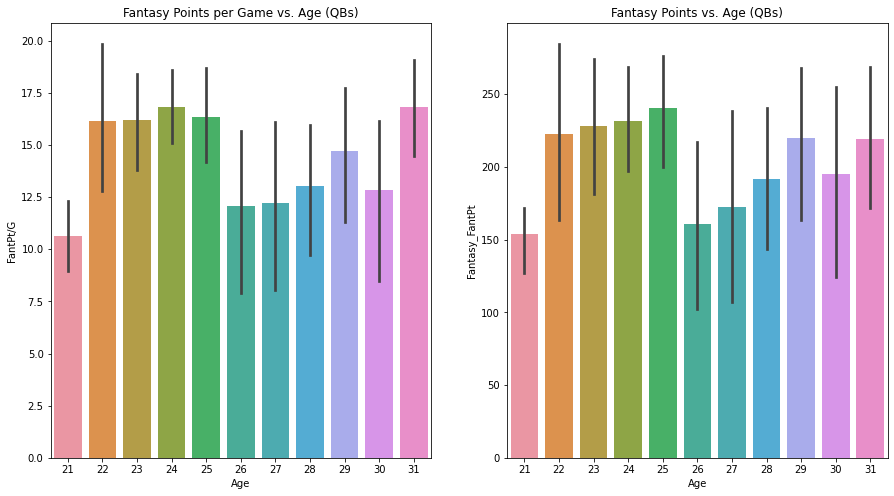

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

_qb_prime_df = prime_df[prime_df['Age']<=31]
qb_prime_df = _qb_prime_df[_qb_prime_df['FantPos'] == 'QB']

sns.barplot(x="Age", y="FantPt/G", data=qb_prime_df, ax=ax1)
ax1.set_title('Fantasy Points per Game vs. Age (QBs)')

sns.barplot(x="Age", y="Fantasy_FantPt", data=qb_prime_df, ax=ax2)
ax2.set_title('Fantasy Points vs. Age (QBs)')

Text(0.5, 1.0, 'Fantasy Points vs. Age (RBs)')

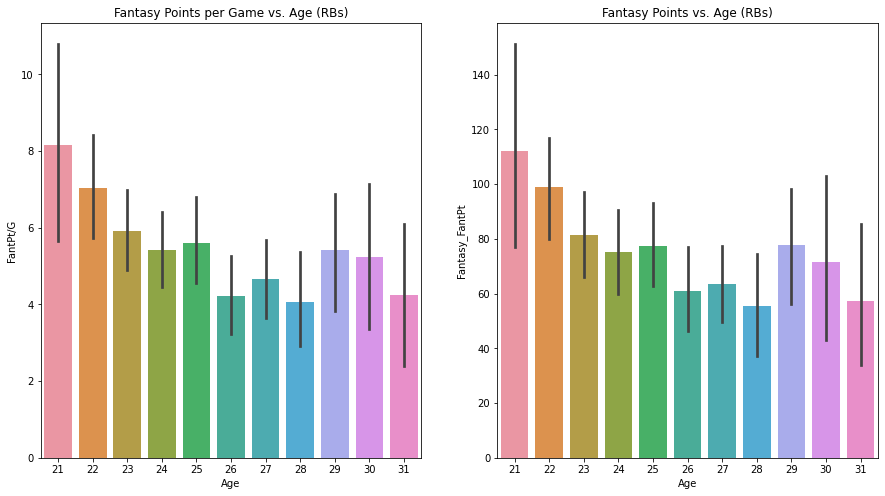

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

_rb_prime_df = prime_df[prime_df['Age']<=31]
rb_prime_df = _rb_prime_df[_rb_prime_df['FantPos'] == 'RB']

sns.barplot(x="Age", y="FantPt/G", data=rb_prime_df, ax=ax1)
ax1.set_title('Fantasy Points per Game vs. Age (RBs)')

sns.barplot(x="Age", y="Fantasy_FantPt", data=rb_prime_df, ax=ax2)
ax2.set_title('Fantasy Points vs. Age (RBs)')

Text(0.5, 1.0, 'Fantasy Points vs. Age (WRs)')

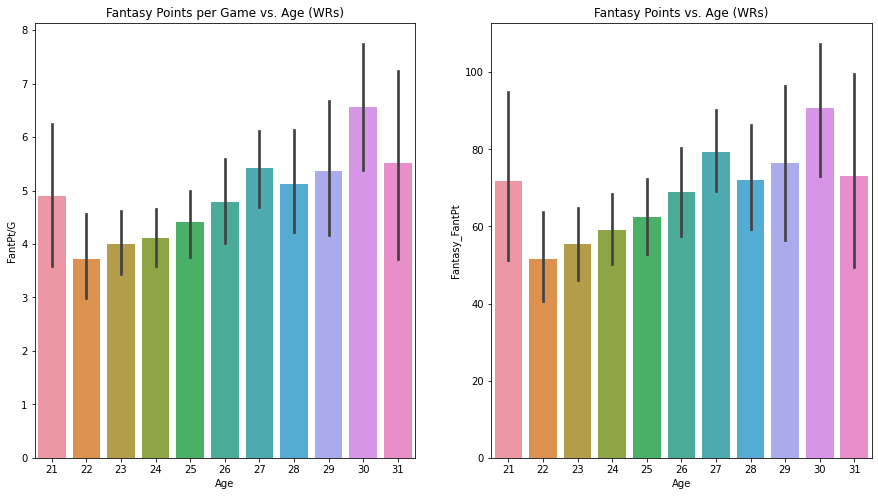

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

_wr_prime_df = prime_df[prime_df['Age']<=31]
wr_prime_df = _wr_prime_df[_wr_prime_df['FantPos'] == 'WR']

sns.barplot(x="Age", y="FantPt/G", data=wr_prime_df, ax=ax1)
ax1.set_title('Fantasy Points per Game vs. Age (WRs)')

sns.barplot(x="Age", y="Fantasy_FantPt", data=wr_prime_df, ax=ax2)
ax2.set_title('Fantasy Points vs. Age (WRs)')

Text(0.5, 1.0, 'Fantasy Points vs. Age (TEs)')

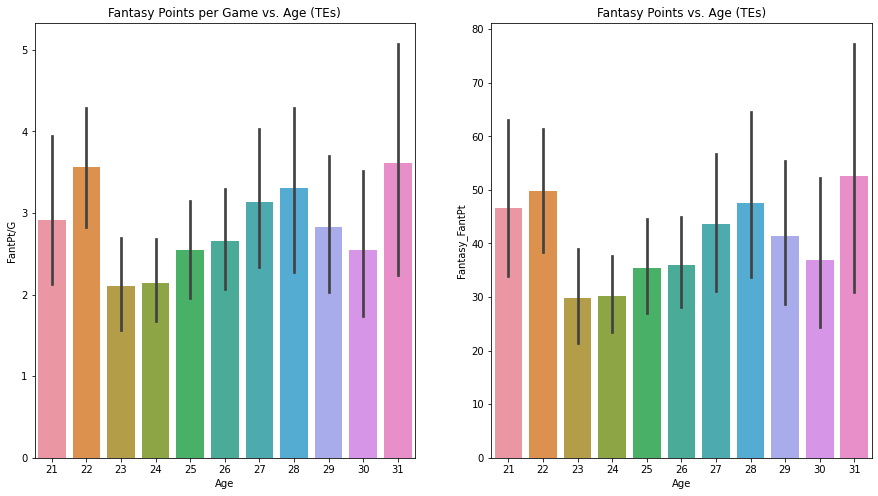

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

_te_prime_df = prime_df[prime_df['Age']<=31]
te_prime_df = _te_prime_df[_te_prime_df['FantPos'] == 'TE']

sns.barplot(x="Age", y="FantPt/G", data=te_prime_df, ax=ax1)
ax1.set_title('Fantasy Points per Game vs. Age (TEs)')

sns.barplot(x="Age", y="Fantasy_FantPt", data=te_prime_df, ax=ax2)
ax2.set_title('Fantasy Points vs. Age (TEs)')